<h1 align="center">Project Report</h1>
<br>

## What is Music Transcription?

Music transcription is the transformation of a musical signal into either a human-readable, or a machine-readable form. Some trained people could achieve this task, with the help of their education and the human intuition. But it is very challenging to develop an automated transcriber, because we need to teach a machine to . We do not realize it often, but there is great mathematical harmony in music. So if we could figure out the aspects of this mathematics, it would be help us develop new technologies for the analysis and synthesis of music.

## Main Attributes of Sound Events

In order to work on a sound event, there are four main qualities which need to be analyzed. These are namely the sound event's *pitch*, *loudness*, *duration* and *timbre* [1]. Here are some brief explanations of these four attributes.

1. **Pitch** refers to the perception of highness or lowness of the sound. In physical terms, this corresponds to the _fundamental frequency_ in the signal. Usually integer multiples of the fundamental frequency ($f_0$) could also be observed, which together form the harmonics of $f_0$. In Western music, going an octave up means doubling the frequency. And this octave is logarithmically quantized as 12 notes. Which means that the k<sup>th</sup> note after $f_0$ has the frequency $f_k = f_0\times2^{k/12}$.<br><br>

2. **Loudness** is the perception of the level of sound pressure in the ear [2]. This attribute depends on how quite or loud the signal is.<br><br>

3. The interval between the onset and the offset of a sound event is called the **duration**.<br><br>

4. **Timbre** of the sound depends on the source. For instance knocking on a door or playing the guitar creates different colors of sound. And although two sources could create sound signals with the same pitch, loudness and duration, they might be easily distinguished by their timbres.

Relating to these attributes of sounds, there are particular problems in music transcription. For example: beat tracking, pitch detection etc.

In [1]:
%matplotlib inline
import importlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import math
import random
import glob, os
import pretty_midi
import scipy
import librosa
import librosa.display

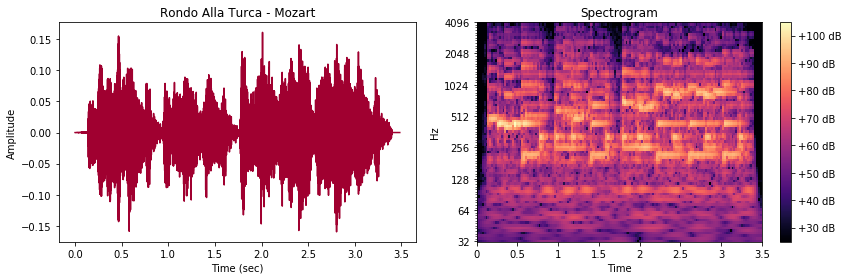

Samples: 76800
Sample Rate: 22050
Frequency Bins: 84
Spectrogram Frames: 151


In [2]:
y, sampleRate = librosa.load("source/examples/alla_turca.wav") # Reading the .wav file
x = np.array([i/sampleRate for i in range(y.size)])
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1) 
plt.plot(x, y, color='#A00030') # Plotting a sample section (Amplitude/Time)
plt.title("Rondo Alla Turca - Mozart")
plt.ylabel("Amplitude")
plt.xlabel("Time (sec)")

D = librosa.cqt(y)
Spec = librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.min)
plt.subplot(1,2,2)
librosa.display.specshow(Spec, y_axis='cqt_hz', x_axis='time', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.title('Spectrogram')
plt.show()
print("Samples: %d\nSample Rate: %d" % (len(y), sampleRate))
print("Frequency Bins: %s\nSpectrogram Frames: %s" % (D.shape[0], D.shape[1]))

Let's analyze a musical excerpt from Mozart's *Rondo alla Turca*. Above, we see the sound intensity (loudness) versus time representation of a 3.5 seconds excerpt from Mozart. The note onsets are clearly visible as sharp spikes. But the peaks in the graph are indistinguishable in terms of their pitch values.

After this, the musical excerpt is analyzed over a spectrogram. The sound signal is divided into different frequency values in every time frame. As the frequency gets higher, we hear higher tones. Per time frame and frequency value, the power output of the signal is represented by a color, ranging from purple to yellow in this case. We could observe the main melody between the frequencies 400-1000 Hz, and the accompanying chords between 200-400 Hz.

## Recent Research

### Onsets and Frames: Dual Objective Piano Transcription

This is a newly released research by Google's *Magenta* team. Magenta focuses on machine learning methods for analyzing and synthesizing music. In this paper, they try to address the problem of polyphonic transcription for piano music using deep neural networks. They use *CNNs* (Convolutional Neural Networks) and *LSTM*s (Long Short Term Memory networks) during this process [4].

They utilize the MAPS dataset, which contains piano pieces both software synthesized and real time recorded. The synthesized pieces are used in training, whereas piano recordings form the test set. The onsets and frames model was trained using TensorFlow on the dataset.

Magenta divides the piano transcription problem into two: onset detection and framewise detection. The framewise detector is allowed to accept a note only if the onset for that pitch has been detected. Notes are more easily identifiable at the beginning, so onset detection is crucial in this model. The team actually experimented with removing the onset detection, but it turned out to be a bad idea. The onset and frame detectors first run a convolutional layer. This is followed by bidirectional LSTMs and fully connected sigmoid layers for both. At the same time, onset predictions are fed into the frame detection process as input.


### Crepe: A Convolutional Representation for Pitch Estimation

CREPE is a data-driven pitch tracking algorithm for monophonic sound signals, producing state-of-the-art results. It stands for "Convolutional Representation for Pitch Estimation". CREPE works directly on time-domain and is based on a deep convolutional neural network [6].

The architecture composes of six convolutional layers with inputs of 1024-sample excerpts with a 16 kHz sampling rate. The output of the convolutional layers passes through a sigmoid activation layer, and the result is a 360-dimensional vector $\hat{y}$. The 360 nodes of this vector represents 360 pitch values. The vector covers six octaves with 20 cent intervals. (100 cents equal to one semitone and 1200 cents equal to an octave) Each value in the vector shows the likelihood of the corresponding pitch value.

![](source/examples/horn.png?raw=true)
![](source/examples/black.png?raw=true)

In the first plot, there is a pitch analysis result of CREPE for an excerpt from Tchaikovsky's *Piano Concerto No. 1* which is played by a horn here. The four notes could be clearly observed as four lines in the graph. They correspond to the frequencies 350, 275, 261 and 231 Hz, slowly descending in pitch. Due of the timbre of the sound and the quality of the recording, we also see other frequency values in the graph. Some of them values are nearly integer multiples of the fundamental frequencies. So these frequencies could as well be analyzed as part of the musical signal, instead of being treated as noise.

The second plot is the CREPE pitch detection result for the beginning of the song *Paint it Black*, a guitar recording. We see that there are many frequencies apart from the main melody, although the sample music is mostly monophonic.

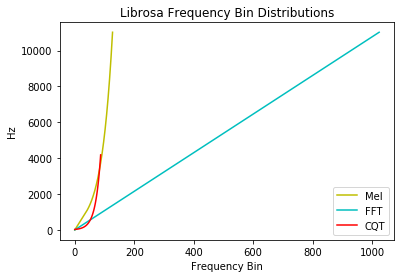

In [3]:
fbins = librosa.mel_frequencies()
plt.plot(fbins, 'y', label='Mel')
fbins = librosa.fft_frequencies()
plt.plot(fbins, 'c', label='FFT')
fbins = librosa.cqt_frequencies(88, 27.50, bins_per_octave=12)
plt.plot(fbins, 'r', label='CQT')
plt.xlabel('Frequency Bin')
plt.ylabel('Hz')
plt.legend()
plt.title('Librosa Frequency Bin Distributions')
plt.show()

## Implementation

### Frequency Bin Distributions

When the spectrograms are calculated from time domain signals, the frequency domain is quantized. There are various methods for spectrogram calculation, which apply different types of frequency scales. Major methods are namely Short Time Fourier Transform (STFT), Constant-Q Transform (CQT) and Mel-Frequency Cepstrum. In the Librosa library, FFT and Mel methods both cover the range of 1Hz-11KHz. But the CQT method covers lower frequencies much better, and the number of frequencies could also be adjusted. CQT has a very suitable frequency distribution between 1Hz and 4KHz, mapping frequency bins to a logarithmic scale. But why this interval? Because human ears are the most sensitive here. [8] Likewise, musical instruments chiefly span this frequency range.

In my implementation, I applied the CQT method with 88 frequency bins (corresponding to 88 notes in the piano keyboard, from A0 to C8) with 12 bins per octave (12 semitones).

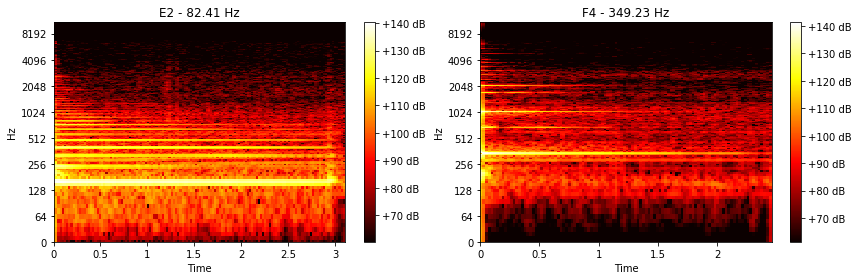

In [4]:
y, sampleRate = librosa.load("source/guitar/Elo0.wav")
Spec = librosa.amplitude_to_db(librosa.magphase(librosa.stft(y))[0], ref=np.min)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1) 
librosa.display.specshow(Spec, y_axis='log', x_axis='time', cmap='hot')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.title('E2 - 82.41 Hz')
y, sampleRate = librosa.load("source/guitar/Ehi1.wav")
Spec = librosa.amplitude_to_db(librosa.magphase(librosa.stft(y))[0], ref=np.min)
plt.subplot(1,2,2)
librosa.display.specshow(Spec, y_axis='log', x_axis='time', cmap='hot')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.title('F4 - 349.23 Hz')
plt.show()

### Musical Data

I collected Piano MIDI files from [d] and modified them as monophonic MIDI files. If there were multiple notes playing at the same time, I selected the note with the highest pitch and removed the rest. If there were any overlapping notes, I cropped them. Thus, I got nearly-monophonic MIDI files from polyphonic ones. I used the Pretty_MIDI Python library for this task. I also created text files and wrote down all the necessary information (frequency, onset, offset). Later when processing the audio files, I would use these information. 

After this, I synthesized WAV files from these monophonic MIDI files. I achieved this by using TiMidity++, which has inherent instrument libraries. But because WAV files take up too much space, I converted these into MP3 files, by using FFmpeg.

### Input and Output

Because there are 88 notes in the piano, I calculated the 88-bin CQT spectrograms of the MP3 files. Then, I found the corresponding pitch frequency for each time frame. (This information is present in the text files)

And for the ground truth, I created a probability vector of length 88 for each time frame. The probability distribution is Gaussian, with STD = 25 cents (cents are logarithmic and 1200 cents = 1 octave), and the correct frequency bin has the probability 1.

To sum up, the input of the model is a 88-element vector, representing the frequency spectrum of a single time frame. And the output of the model is a probability vector of length 88. According to these probabilities, I will try to predict which note is being played at the given time.

In [2]:
import neural as neu
import importlib
import numpy as np

Using TensorFlow backend.


In [ ]:
importlib.reload(neu)

In [ ]:
neu.initData()
print('Dataset Ready!..')

In [3]:
neu.modelClear()
neu.modelInit()
print('Model Initialized!..')

Model Initialized!..


In [ ]:
neu.modelSummary()

### Neural Network Model

My neural network aims to transcribe monophonic piano music. It takes spectrogram data as input and provides pitch probabilities as output.

The model model starts with an Input layer which takes 88-element vectors as input. This corresponds to the 88 notes in the piano. So each vector input represents the frequency spectrum of a single time frame. Higher values mean greater energy for the particular frequency during that particular time frame.

Following the Input layer, there is a Dense layer with Relu activation. In a Dense layer, each input neuron is connected to all the output neurons. So there are 88 x 88 = 7,744 parameters to train, plus 88 bias parameters which add up to 7,832. This layer is followed by a Dropout layer which reduces the output values to the factor of 0.15, to avoid overfitting.

After the first Dense layer, there is another one with Sigmoid activation. And finally there is a third Dense layer with Softmax activation. The reason for using the Softmax activation function is that it applies exponential normalization to the output. This is a classification problem and each element in the output vector represents a probability. So the softmax function is suitable for this task, mapping all the values to the range of 0-1. Finally, since there are 3 Dense layers, the total number of trainable parameters would be 3 x 7,832 = 23,496.

Below is a visualization of my neural network, with Dense and Dropout layers together. (Graph drawn at [10])

![](model_graph.png?raw=true)

## Results

In [ ]:
neu.modelFit()

In [36]:
neu.modelSaveWeights("weights/pianoWeights")

In [26]:
neu.modelLoadWeights("weights/pianoWeights")

In [ ]:
neu.plotHistory()

![](results/accuracy-32.png?raw=true)
![](results/loss-32.png?raw=true)

### Transcription Examples

Here are some monophonic pitch predictions for two musical samples. The first two are from *Toccata and Fugue in D Minor - Bach* (samples recorded by me), and the second two are from *Fur Elise - Beethoven* (samples taken from [e]).

The spectogram is plotted first, together with the ground truth pitch values. Secondly, the pitch predictions are displayed for comparison.

In [ ]:
filename = "source/examples/toccata.wav" # Example transcription code
neu.testFile(filename)

![](results/result-toccata.png?raw=true)

![](results/result-toccata2.png?raw=true)

![](results/result-fur_elise.png?raw=true)

![](results/result-fur_elise2.png?raw=true)

## Further Ideas

### Hidden Markov Models

*Hidden Markov Models* (HMM) are used extensively for language processing since they are *sequence model*s [7]. As language is made up of sequences of phonemes and words, music is made up of note sequences. So because of the similarity, HMMs could reasonably be used for musical transcription as well. Practically, we could collect statistics from musical sequences and then make inferences about unencountered music.

The only thing we know for certain are out observations, but we would like to reach information that is unknown to us. In a Hidden Markov Model, hidden states are the unknown information and they probabilistically make transitions to other states. The observations in the model are also produced probabilistically from hidden states. For pitch detection, HMMs could play a supporting role since we could analyze ground truth from musical data. And we could probabilistically represent note transitions and observations.

Above, sample guitar MIDI files are analyzed for pitch transitions [8]. Pitch intervals are logarithmic, and each transition is represented in terms of logarithmic steps. Transition probabilities are normalized for every midi file and then their average is calculated for the final plot. We could fit the average probabilities on a normal distribution by calculating the mean and the deviation. Although we could find a formulation for this phenomenon, preserving the irregularities could be helpful.

Apparently, the probability distribution has larger values at small step sizes. But there are also irregular trends and spikes due to issues of musical harmony.  Some transitions are more pleasant to our ears, thus preferred more often.

In [5]:
import hmm
import importlib

In [ ]:
importlib.reload(hmm)

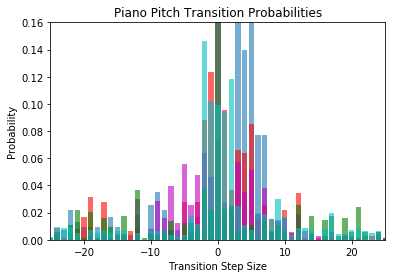

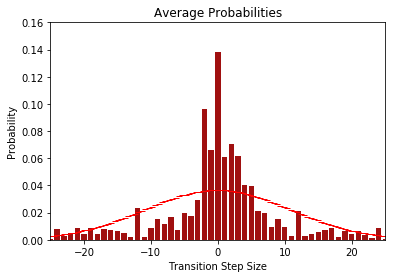

In [10]:
hmm.demonstration()

## References

1. Klapuri, Anssi, and Manuel Davy. Signal Processing Methods for Music Transcription. Springer, 2006.
1. “Sound.” Wikiwand, https://www.wikiwand.com/en/Sound#/Sound_wave_properties_and_characteristics.
1. Goodfellow, Ian, et al. Deep Learning. MIT Press, 2016.
1. Hawthorne, et al. Onsets and Frames: Dual-Objective Piano Transcription. 30 Oct. 2017, https://arxiv.org/abs/1710.11153.
1. Olah, Christopher. “Understanding LSTM Networks.” Colah's Blog, 27 Aug. 2015, https://colah.github.io/posts/2015-08-Understanding-LSTMs/.
1. Kim, Jong Wook, et al. Crepe: A Convolutional Representation for Pitch Estimation. New York University, Feb. 2018.
1. “Hidden Markov Models.” Speech and Language Processing, by Dan Jurafsky and James H. Martin, 2016.
1. “How Does a Guitar Work?” How a Guitar Works, https://newt.phys.unsw.edu.au/music/guitar/guitarintro.html.
1. Neural Network Foundations, Explained: Activation Function, https://www.kdnuggets.com/2017/09/neural-network-foundations-explained-activation-function.html.
1. CS Academy, https://csacademy.com/app/graph_editor/

## Data
 
a. Classical Guitar Midi Archives, https://www.classicalguitarmidi.com.<br>
b. Simple Pitch Detector, https://www.kaggle.com/asparago/simple-pitch-detector.<br>
c. guitar-tuner-notes, https://soundcloud.com/guitar-tuner-notes.<br>
d. Classical MIDI Files, https://www.mfiles.co.uk/classical-midi.htm.<br>
e. Fur Elise (Piano Version), https://www.youtube.com/watch?v=_mVW8tgGY_w.<br>